In [1]:
!pip install --upgrade pip
!pip install datasets accelerate transformers tqdm torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib
!pip install -U accelerate
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no


In [2]:
from transformers import TrainingArguments, AutoFeatureExtractor, ResNetForImageClassification, ResNetConfig, Trainer
import torch
import numpy as np
from datasets import load_dataset

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='cuda:0')


In [4]:
def load_data():
    d_types = ['train'] # 60k images
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'mnist',
            split=d,
        ))
    return datasets

# 94% for validation, 1% for test and 5% for training
dataset = load_data()[0].map(lambda x: {'image': torch.tensor(np.repeat(np.array(x['image'])[:, :, np.newaxis], 3, axis=2)), 'label': x['label']})



In [5]:
split = dataset.train_test_split(test_size=0.94)
temp_split = split['train'].train_test_split(test_size=1/6)
dataset_train = temp_split['train']
dataset_test = temp_split['test']
dataset_valid = split['test']
dataset_train, dataset_test, dataset_valid

(Dataset({
     features: ['image', 'label'],
     num_rows: 3000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 56400
 }))

In [6]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label'].names
num_classes, labels

(10, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [7]:
dataset_train['image'][1].size

(28, 28)

In [20]:
# import feature extraction model
model_id = 'microsoft/resnet-50'

feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id
)
config = ResNetConfig()
config.num_labels = num_classes
model = ResNetForImageClassification(config)
model = model.from_pretrained(
    model_id,  # classification head
).train().to(device)

model.num_parameters()

25557032

In [9]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)



In [10]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


/tmp/ipykernel_13226/1389652664.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
from transformers import Trainer

eval_save_step = 100

# training the model
training_args = TrainingArguments(
  output_dir="./cnn_model",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=5,
  save_steps=eval_save_step,
  eval_steps=eval_save_step,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=False)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

  2%|▏         | 10/470 [00:07<02:15,  3.38it/s]

{'loss': 7.2699, 'learning_rate': 0.00019574468085106384, 'epoch': 0.11}


  4%|▍         | 20/470 [00:10<01:56,  3.87it/s]

{'loss': 5.715, 'learning_rate': 0.00019148936170212768, 'epoch': 0.21}


  6%|▋         | 30/470 [00:12<01:43,  4.24it/s]

{'loss': 4.2164, 'learning_rate': 0.0001872340425531915, 'epoch': 0.32}


  9%|▊         | 41/470 [00:14<01:25,  5.04it/s]

{'loss': 2.7825, 'learning_rate': 0.00018297872340425532, 'epoch': 0.43}


 11%|█         | 51/470 [00:16<01:22,  5.10it/s]

{'loss': 1.784, 'learning_rate': 0.00017872340425531915, 'epoch': 0.53}


 13%|█▎        | 60/470 [00:18<01:27,  4.70it/s]

{'loss': 1.1513, 'learning_rate': 0.00017446808510638298, 'epoch': 0.64}


 15%|█▍        | 70/470 [00:21<01:53,  3.53it/s]

{'loss': 1.0236, 'learning_rate': 0.00017021276595744682, 'epoch': 0.74}


 17%|█▋        | 80/470 [00:23<01:31,  4.28it/s]

{'loss': 0.711, 'learning_rate': 0.00016595744680851065, 'epoch': 0.85}


 19%|█▉        | 90/470 [00:25<01:32,  4.10it/s]

{'loss': 0.6479, 'learning_rate': 0.00016170212765957446, 'epoch': 0.96}


 21%|██▏       | 100/470 [00:28<01:32,  4.00it/s]

{'loss': 0.4359, 'learning_rate': 0.00015744680851063832, 'epoch': 1.06}


                                                 
 21%|██▏       | 100/470 [00:32<01:32,  4.00it/s]

{'eval_loss': 2.738985300064087, 'eval_accuracy': 0.3416666666666667, 'eval_runtime': 4.1253, 'eval_samples_per_second': 145.443, 'eval_steps_per_second': 18.18, 'epoch': 1.06}


 23%|██▎       | 110/470 [00:34<01:34,  3.80it/s]

{'loss': 0.3832, 'learning_rate': 0.00015319148936170213, 'epoch': 1.17}


 26%|██▌       | 121/470 [00:37<01:09,  5.01it/s]

{'loss': 0.3572, 'learning_rate': 0.00014893617021276596, 'epoch': 1.28}


 28%|██▊       | 131/470 [00:39<01:07,  5.01it/s]

{'loss': 0.2998, 'learning_rate': 0.0001446808510638298, 'epoch': 1.38}


 30%|███       | 141/470 [00:41<01:07,  4.87it/s]

{'loss': 0.2934, 'learning_rate': 0.00014042553191489363, 'epoch': 1.49}


 32%|███▏      | 151/470 [00:43<01:03,  4.99it/s]

{'loss': 0.2933, 'learning_rate': 0.00013617021276595746, 'epoch': 1.6}


 34%|███▍      | 161/470 [00:45<01:01,  5.04it/s]

{'loss': 0.241, 'learning_rate': 0.00013191489361702127, 'epoch': 1.7}


 36%|███▋      | 171/470 [00:47<01:00,  4.96it/s]

{'loss': 0.1706, 'learning_rate': 0.00012765957446808513, 'epoch': 1.81}


 39%|███▊      | 181/470 [00:49<00:57,  5.04it/s]

{'loss': 0.2158, 'learning_rate': 0.00012340425531914893, 'epoch': 1.91}


 41%|████      | 191/470 [00:51<00:53,  5.23it/s]

{'loss': 0.1201, 'learning_rate': 0.00011914893617021277, 'epoch': 2.02}


 43%|████▎     | 200/470 [00:52<00:53,  5.04it/s]

{'loss': 0.137, 'learning_rate': 0.00011489361702127661, 'epoch': 2.13}


                                                 
 43%|████▎     | 200/470 [00:56<00:53,  5.04it/s]

{'eval_loss': 0.4768838584423065, 'eval_accuracy': 0.86, 'eval_runtime': 3.7275, 'eval_samples_per_second': 160.968, 'eval_steps_per_second': 20.121, 'epoch': 2.13}


 45%|████▍     | 210/470 [00:59<01:13,  3.55it/s]

{'loss': 0.1048, 'learning_rate': 0.00011063829787234043, 'epoch': 2.23}


 47%|████▋     | 220/470 [01:01<01:00,  4.14it/s]

{'loss': 0.0981, 'learning_rate': 0.00010638297872340425, 'epoch': 2.34}


 49%|████▉     | 230/470 [01:04<00:58,  4.09it/s]

{'loss': 0.1152, 'learning_rate': 0.00010212765957446809, 'epoch': 2.45}


 51%|█████     | 240/470 [01:06<00:55,  4.15it/s]

{'loss': 0.1176, 'learning_rate': 9.787234042553192e-05, 'epoch': 2.55}


 53%|█████▎    | 250/470 [01:09<00:54,  4.05it/s]

{'loss': 0.0379, 'learning_rate': 9.361702127659576e-05, 'epoch': 2.66}


 55%|█████▌    | 260/470 [01:11<00:50,  4.16it/s]

{'loss': 0.0605, 'learning_rate': 8.936170212765958e-05, 'epoch': 2.77}


 57%|█████▋    | 270/470 [01:14<00:50,  3.98it/s]

{'loss': 0.1042, 'learning_rate': 8.510638297872341e-05, 'epoch': 2.87}


 60%|█████▉    | 281/470 [01:16<00:42,  4.47it/s]

{'loss': 0.0964, 'learning_rate': 8.085106382978723e-05, 'epoch': 2.98}


 62%|██████▏   | 290/470 [01:18<00:42,  4.21it/s]

{'loss': 0.0572, 'learning_rate': 7.659574468085106e-05, 'epoch': 3.09}


 64%|██████▍   | 300/470 [01:21<00:40,  4.18it/s]

{'loss': 0.0354, 'learning_rate': 7.23404255319149e-05, 'epoch': 3.19}


                                                 
 64%|██████▍   | 300/470 [01:24<00:40,  4.18it/s]

{'eval_loss': 0.1034337729215622, 'eval_accuracy': 0.965, 'eval_runtime': 3.6721, 'eval_samples_per_second': 163.393, 'eval_steps_per_second': 20.424, 'epoch': 3.19}


 66%|██████▌   | 310/470 [01:27<00:46,  3.47it/s]

{'loss': 0.0387, 'learning_rate': 6.808510638297873e-05, 'epoch': 3.3}


 68%|██████▊   | 320/470 [01:29<00:36,  4.16it/s]

{'loss': 0.0618, 'learning_rate': 6.382978723404256e-05, 'epoch': 3.4}


 70%|███████   | 330/470 [01:32<00:28,  4.93it/s]

{'loss': 0.0464, 'learning_rate': 5.9574468085106384e-05, 'epoch': 3.51}


 72%|███████▏  | 340/470 [01:34<00:31,  4.10it/s]

{'loss': 0.0588, 'learning_rate': 5.531914893617022e-05, 'epoch': 3.62}


 74%|███████▍  | 350/470 [01:36<00:28,  4.21it/s]

{'loss': 0.0337, 'learning_rate': 5.1063829787234044e-05, 'epoch': 3.72}


 77%|███████▋  | 360/470 [01:39<00:25,  4.37it/s]

{'loss': 0.053, 'learning_rate': 4.680851063829788e-05, 'epoch': 3.83}


 79%|███████▉  | 371/470 [01:41<00:19,  5.02it/s]

{'loss': 0.0408, 'learning_rate': 4.2553191489361704e-05, 'epoch': 3.94}


 81%|████████  | 381/470 [01:43<00:17,  5.15it/s]

{'loss': 0.0391, 'learning_rate': 3.829787234042553e-05, 'epoch': 4.04}


 83%|████████▎ | 390/470 [01:45<00:16,  4.84it/s]

{'loss': 0.0189, 'learning_rate': 3.4042553191489365e-05, 'epoch': 4.15}


 85%|████████▌ | 400/470 [01:47<00:13,  5.01it/s]

{'loss': 0.0429, 'learning_rate': 2.9787234042553192e-05, 'epoch': 4.26}


                                                 
 85%|████████▌ | 400/470 [01:50<00:13,  5.01it/s]

{'eval_loss': 0.07702630013227463, 'eval_accuracy': 0.9766666666666667, 'eval_runtime': 3.4989, 'eval_samples_per_second': 171.483, 'eval_steps_per_second': 21.435, 'epoch': 4.26}


 87%|████████▋ | 410/470 [01:53<00:17,  3.45it/s]

{'loss': 0.0152, 'learning_rate': 2.5531914893617022e-05, 'epoch': 4.36}


 89%|████████▉ | 420/470 [01:56<00:12,  4.03it/s]

{'loss': 0.0207, 'learning_rate': 2.1276595744680852e-05, 'epoch': 4.47}


 91%|█████████▏| 430/470 [01:58<00:09,  4.07it/s]

{'loss': 0.0303, 'learning_rate': 1.7021276595744682e-05, 'epoch': 4.57}


 94%|█████████▎| 440/470 [02:00<00:06,  4.29it/s]

{'loss': 0.008, 'learning_rate': 1.2765957446808511e-05, 'epoch': 4.68}


 96%|█████████▌| 450/470 [02:03<00:04,  4.30it/s]

{'loss': 0.0139, 'learning_rate': 8.510638297872341e-06, 'epoch': 4.79}


 98%|█████████▊| 460/470 [02:05<00:02,  4.29it/s]

{'loss': 0.0197, 'learning_rate': 4.255319148936171e-06, 'epoch': 4.89}


100%|██████████| 470/470 [02:07<00:00,  3.68it/s]


{'loss': 0.0118, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 127.7213, 'train_samples_per_second': 117.443, 'train_steps_per_second': 3.68, 'train_loss': 0.6304153577761448, 'epoch': 5.0}
***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.6304
  train_runtime            = 0:02:07.72
  train_samples_per_second =    117.443
  train_steps_per_second   =       3.68


In [12]:
# evaluate with valid
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 7050/7050 [05:23<00:00, 21.76it/s]

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9671
  eval_loss               =     0.1082
  eval_runtime            = 0:05:24.08
  eval_samples_per_second =     174.03
  eval_steps_per_second   =     21.754


Text(0.5, 1.0, 'ResNet: Loss over train steps')

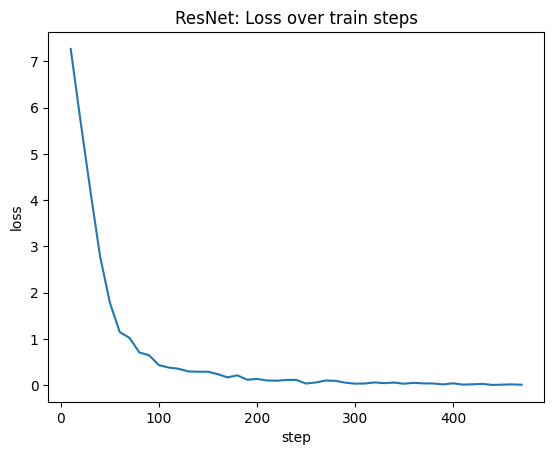

In [13]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ResNet: Loss over train steps')


In [14]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './cnn_model'
model_finetuned = ResNetForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = AutoFeatureExtractor.from_pretrained(model_name_or_path)


/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [15]:
def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["label"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    return predicted_label


In [19]:
import random
index = random.randint(0, len(dataset_valid))
print("Predicted "+str(predict(dataset_valid[index])))
dataset_valid[index]["image"]

Predicted 1
